### d-prime predictions from FA simulations

In [1]:
from loader import load_pop_metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['font.size'] = 12

import sys
sys.path.append("/auto/users/hellerc/code/projects/nat_pupil_ms/")
from global_settings import CPN_SITES, HIGHR_SITES
# decoding stuff
import charlieTools.nat_sounds_ms.decoding as decoding
from path_settings import DPRIME_DIR
import os

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2022-03-22 010224.log


In [2]:
sites = CPN_SITES + HIGHR_SITES
batches = [331]*len(CPN_SITES) + [322 if s.startswith("BOL")==False else 294 for s in HIGHR_SITES]

In [30]:
noise = ""
noise331 = "_noiseDim-6"
loader = decoding.DecodingResults()

raw_df = []
fa_null_df = []
fa_ind_df = []
fa_full_df = []
for i, (s, b) in enumerate(zip(sites, batches)):
    if b == 331:
        _noise = noise331
    else:
        _noise = noise
    rmodel = f"dprime_jk10_zscore_fixtdr2-fa{_noise}"                    # reaw data
    famodel_null = f"dprime_faModel.ind-null_jk10_zscore_fixtdr2-fa{_noise}" # fixed cov matrix between lrg / small
    famodel_ind = f"dprime_faModel.ind_jk10_zscore_fixtdr2-fa{_noise}"   # only change ind. variance. (diag cov matrix)
    #famodel = f"dprime_faModel.rr1_jk10_zscore_fixtdr2-fa{_noise}"           # full (reduced) rank cov matrix
    famodel = f"dprime_faModel_jk10_zscore_fixtdr2-fa{_noise}"  

    fn = os.path.join(DPRIME_DIR, str(b), s, rmodel+'_TDR.pickle')
    results = loader.load_results(fn, cache_path=None, recache=False)
    df = results.numeric_results.loc[results.evoked_stimulus_pairs]

    fn = os.path.join(DPRIME_DIR, str(b), s, famodel_null+'_TDR.pickle')
    results = loader.load_results(fn, cache_path=None, recache=False)
    df_null_fa = results.numeric_results.loc[results.evoked_stimulus_pairs]

    fn = os.path.join(DPRIME_DIR, str(b), s, famodel_ind+'_TDR.pickle')
    results = loader.load_results(fn, cache_path=None, recache=False)
    df_ind_fa = results.numeric_results.loc[results.evoked_stimulus_pairs]

    fn = os.path.join(DPRIME_DIR, str(b), s, famodel+'_TDR.pickle')
    results = loader.load_results(fn, cache_path=None, recache=False)
    df_fa = results.numeric_results.loc[results.evoked_stimulus_pairs]

    df["delta"] = (df["bp_dp"]-df["sp_dp"]) / (df["bp_dp"]+df["sp_dp"])
    df["site"] = s
    df["batch"] = b

    df_null_fa["delta"] = (df_null_fa["bp_dp"]-df_null_fa["sp_dp"])/(df_null_fa["bp_dp"]+df_null_fa["sp_dp"])
    df_null_fa["site"] = s
    df_null_fa["batch"] = b

    df_ind_fa["delta"] = (df_ind_fa["bp_dp"]-df_ind_fa["sp_dp"])/(df_ind_fa["bp_dp"]+df_ind_fa["sp_dp"])
    df_ind_fa["site"] = s
    df_ind_fa["batch"] = b

    df_fa["delta"] = (df_fa["bp_dp"]-df_fa["sp_dp"])/(df_fa["bp_dp"]+df_fa["sp_dp"])
    df_fa["site"] = s
    df_fa["batch"] = b

    raw_df.append(df)
    fa_null_df.append(df_null_fa)
    fa_ind_df.append(df_ind_fa)
    fa_full_df.append(df_fa)

df = pd.concat(raw_df)
df_null_fa = pd.concat(fa_null_df)
df_ind_fa = pd.concat(fa_ind_df)
df_full_fa = pd.concat(fa_full_df)


[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_jk10_zscore_fixtdr2-fa_noiseDim-6_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_faModel.ind-null_jk10_zscore_fixtdr2-fa_noiseDim-6_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_faModel.ind_jk10_zscore_fixtdr2-fa_noiseDim-6_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_faModel_jk10_zscore_fixtdr2-fa_noiseDim-6_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT026a/dprime_jk10_zscore_fixtdr2-fa_noiseDim-6_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT026a/dprime_faModel.ind-null_jk10_zscore_fixtdr2-fa_noiseDim-6_TDR.pickle
[root INFO] loading pickle from /auto/users/he

In [31]:
mask = df["delta"].isna()==False
df = df[mask]
df_null_fa = df_null_fa[mask]
df_ind_fa = df_ind_fa[mask]
df_full_fa = df_full_fa[mask]

In [32]:
columns = ["bp_sv", "sp_sv", "bp_dim", "sp_dim", "bp_dim_sem", "sp_dim_sem", "bp_ls", "sp_ls", "site", "batch"]
metrics = pd.DataFrame(columns=columns, index=range(len(sites)))
metrics_all = pd.DataFrame(columns=columns, index=range(len(sites)))
for i, (s, b) in enumerate(zip(sites, batches)):
    r = load_pop_metrics(site=s, batch=b, modelname="factor_analysis")
    metrics.iloc[i] = [r["bp_sv"], r["sp_sv"], r["bp_dim95"], r["sp_dim95"], r["bp_dim_sem"], r["sp_dim_sem"], r["bp_loading_sim"], r["sp_loading_sim"], s, b]
    metrics_all.iloc[i] = [r["final_fit"]["bp_sv_all"], r["final_fit"]["sp_sv_all"], r["final_fit"]["bp_dim95_all"], r["final_fit"]["sp_dim95_all"], r["bp_dim_sem"], r["sp_dim_sem"], r["final_fit"]["bp_ls_all"], r["final_fit"]["sp_ls_all"], s, b]

t = {k: float for k in columns if (k!="site") & (k!="batch")}
metrics = metrics.astype(t)
metrics_all = metrics_all.astype(t)

In [33]:
df = df.merge(metrics, on=["site", "batch"])
df_null_fa = df_null_fa.merge(metrics, on=["site", "batch"])
df_ind_fa = df_ind_fa.merge(metrics, on=["site", "batch"])
df_full_fa = df_full_fa.merge(metrics, on=["site", "batch"])

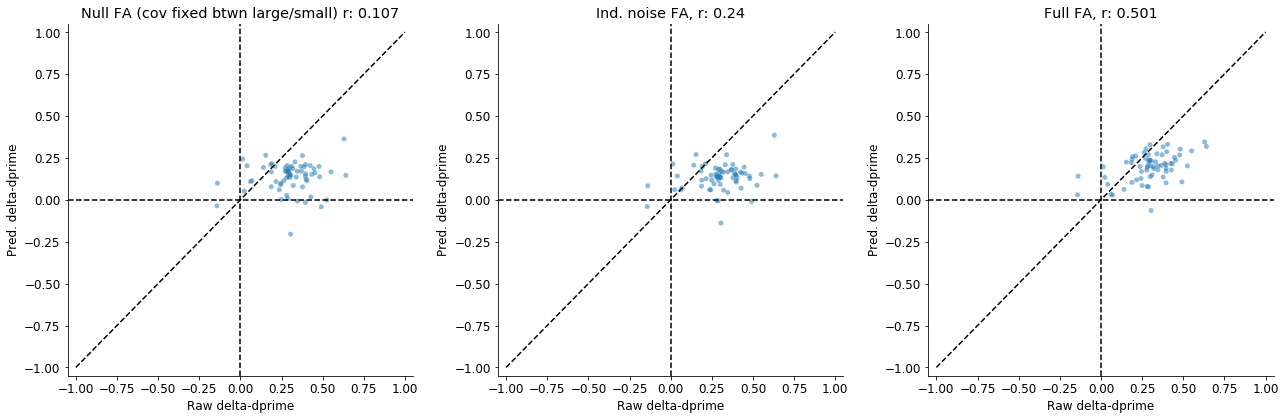

In [34]:
m = (df.site=="AMT020a") & (df.batch==331) #df.site=="CRD017c" #(df.bp_dp_sem<1) & (df.sp_dp_sem<1) #(df.batch==331) #| (df.batch==331)
f, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].scatter(df[m]["delta"], df_null_fa[m]["delta"], s=25, alpha=0.5, edgecolor="none")
cc = np.corrcoef(df[m]["delta"], df_null_fa[m]["delta"])[0, 1]
ax[0].set_title(f"Null FA (cov fixed btwn large/small) r: {round(cc, 3)}")

ax[1].scatter(df[m]["delta"], df_ind_fa[m]["delta"], s=25, alpha=0.5, edgecolor="none")
cc = np.corrcoef(df[m]["delta"], df_ind_fa[m]["delta"])[0, 1]
ax[1].set_title(f"Ind. noise FA, r: {round(cc, 3)}")

ax[2].scatter(df[m]["delta"], df_full_fa[m]["delta"], s=25, alpha=0.5, edgecolor="none")
cc = np.corrcoef(df[m]["delta"], df_full_fa[m]["delta"])[0, 1]
ax[2].set_title(f"Full FA, r: {round(cc, 3)}")

for a in ax:
    a.axvline(0, linestyle="--", color="k")
    a.axhline(0, linestyle="--", color="k")
    a.plot([-1, 1], [-1, 1], "k--")
    a.set_xlim(-1.05, 1.05)
    a.set_ylim(-1.05, 1.05)
    a.set_xlabel("Raw delta-dprime")
    a.set_ylabel("Pred. delta-dprime")

f.tight_layout()


In [35]:
import scipy.stats as ss
import statsmodels.api as sm

In [36]:
paired_err = pd.DataFrame(columns=["err_diff", "r_diff", "r2_diff", "pval_err", "comp", "site", "batch"])
for i, (s, b) in enumerate(zip(sites, batches)):
    m = (df.site==s) & (df.batch==b)
    e1 = abs(df_null_fa[m]["delta"] - df[m]["delta"])
    e2 = abs(df_ind_fa[m]["delta"] - df[m]["delta"])
    e3 = abs(df_full_fa[m]["delta"] - df[m]["delta"])
    r1, pr1 = ss.pearsonr(df_null_fa[m]["delta"], df[m]["delta"])
    r2, pr2 = ss.pearsonr(df_ind_fa[m]["delta"], df[m]["delta"])
    r3, pr3 = ss.pearsonr(df_full_fa[m]["delta"], df[m]["delta"])
    e1_e2_p = ss.wilcoxon(e1, e2).pvalue
    e2_e3_p = ss.wilcoxon(e2, e3).pvalue
    e1_e3_p = ss.wilcoxon(e1, e3).pvalue

    # fit models
    X = df[m][["delta"]]
    sm.add_constant(X)
    y = df_null_fa[m]["delta"]
    model = sm.OLS(y, X).fit()
    r2_1 = model.rsquared
    df_null_fa.loc[(df_null_fa.site==s) & (df_null_fa.batch==b), "r2"] = r2_1
    y = df_ind_fa[m]["delta"]
    model = sm.OLS(y, X).fit()
    r2_2 = model.rsquared
    df_ind_fa.loc[(df_null_fa.site==s) & (df_null_fa.batch==b), "r2"] = r2_2
    y = df_full_fa[m]["delta"]
    model = sm.OLS(y, X).fit()
    r2_3 = model.rsquared
    df_full_fa.loc[(df_null_fa.site==s) & (df_null_fa.batch==b), "r2"] = r2_3

    paired_err = pd.concat([paired_err, pd.DataFrame(index=paired_err.columns, columns=[1],data=[
        (e2-e1).mean(),
        (r2-r1),
        r2_2 - r2_1,
        e1_e2_p,
        "null_ind",
        s,
        b
    ]).T])
    paired_err = pd.concat([paired_err, pd.DataFrame(index=paired_err.columns, columns=[1],data=[
        (e3-e2).mean(),
        (r3-r2),
        r2_3-r2_2,
        e2_e3_p,
        "ind_full",
        s,
        b
    ]).T])
    paired_err = pd.concat([paired_err, pd.DataFrame(index=paired_err.columns, columns=[1],data=[
        (e3-e1).mean(),
        (r3-r1),
        r2_3-r2_1,
        e1_e3_p,
        "null_full",
        s,
        b
    ]).T])

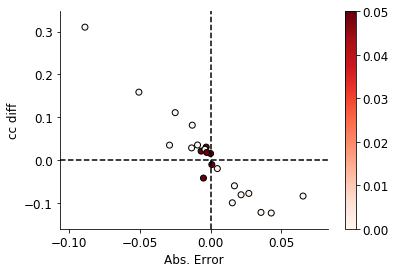

In [37]:
d = paired_err[paired_err.comp=="null_full"]
d = d[d.batch==322]
plt.scatter(d["err_diff"], d["r2_diff"], c=d["pval_err"], vmin=-0.0, vmax=0.05, cmap="Reds", edgecolor="k")
plt.axhline(0, linestyle="--", color="k")
plt.axvline(0, linestyle="--", color="k")
plt.xlabel("Abs. Error")
plt.ylabel("cc diff")
plt.colorbar()

In [38]:
bf = d[(d.err_diff>0) & (d.r2_diff<0) & (d.pval_err<0.05)]
bf

,err_diff,r_diff,r2_diff,pval_err,comp,site,batch
1,0.0428828,-0.0491487,-0.123711,6.64547e-96,null_full,DRX006b.e1:64,322
1,0.0356401,-0.0284742,-0.122311,6.92753e-38,null_full,DRX007a.e1:64,322
1,0.0154007,0.0431057,-0.0999009,1.6891e-11,null_full,DRX008b.e1:64,322
1,0.0215729,0.0148937,-0.0811465,2.64714e-39,null_full,DRX008b.e65:128,322
1,0.027034,0.0551896,-0.0779938,9.41605e-19,null_full,CRD017c,322
1,0.0168914,0.0220456,-0.0602263,1.89304e-24,null_full,TNC012a,322
1,0.0653417,-0.0334202,-0.0841317,1.23549e-38,null_full,TNC013a,322
1,0.00481025,0.0141974,-0.020011,0.000459533,null_full,TNC017a,322


In [39]:
df[df.site.isin(bf.site)].groupby(by=["site", "batch"]).mean()[["bp_dim", "sp_dim"]]

bp_dim    sp_dim
site            batch                     
CRD017c         322     5.000000  5.000000
DRX006b.e1:64   322     7.044444  3.000000
DRX007a.e1:64   322     2.900000  3.700000
DRX008b.e1:64   322     4.000000  4.000000
DRX008b.e65:128 322     5.944444  3.000000
TNC012a         322     4.044444  3.955556
TNC013a         322     5.033333  2.000000
                331     8.000000  5.066667
TNC017a         322     2.144444  2.388889
                331    10.166667  9.033333

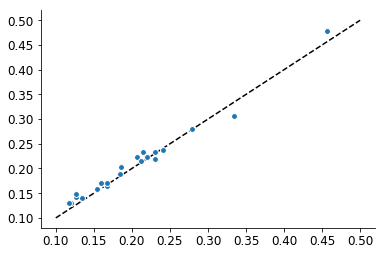

In [40]:
# the variance of delta dprime within site is better explained by full model
# so indep noise can give negative deltas, but it tends to be more consitent for that site
m = df.batch==322
plt.scatter(df_ind_fa[m].groupby(by=["site", "batch"]).std()["delta"], df_full_fa[m].groupby(by=["site", "batch"]).std()["delta"], s=35, edgecolor="white")
plt.plot([0.1, 0.5], [0.1, 0.5], "k--", zorder=-1)

In [41]:
e1_std = abs(df_null_fa.groupby(by=["site", "batch"]).std()["delta"] - df.groupby(by=["site", "batch"]).std()["delta"])
e2_std = abs(df_ind_fa.groupby(by=["site", "batch"]).std()["delta"] - df.groupby(by=["site", "batch"]).std()["delta"])
e3_std = abs(df_full_fa.groupby(by=["site", "batch"]).std()["delta"] - df.groupby(by=["site", "batch"]).std()["delta"])

norm = df.groupby(by=["site", "batch"]).std()["delta"]
e1_std /= norm
e2_std /= norm
e3_std /= norm

e1_mean = abs(df_null_fa.groupby(by=["site", "batch"]).mean()["delta"] - df.groupby(by=["site", "batch"]).mean()["delta"])
e2_mean = abs(df_ind_fa.groupby(by=["site", "batch"]).mean()["delta"] - df.groupby(by=["site", "batch"]).mean()["delta"])
e3_mean = abs(df_full_fa.groupby(by=["site", "batch"]).mean()["delta"] - df.groupby(by=["site", "batch"]).mean()["delta"])

r2_1 = df_null_fa.groupby(by=["site", "batch"]).mean()["r2"]
r2_2 = df_ind_fa.groupby(by=["site", "batch"]).mean()["r2"]
r2_3 = df_full_fa.groupby(by=["site", "batch"]).mean()["r2"]

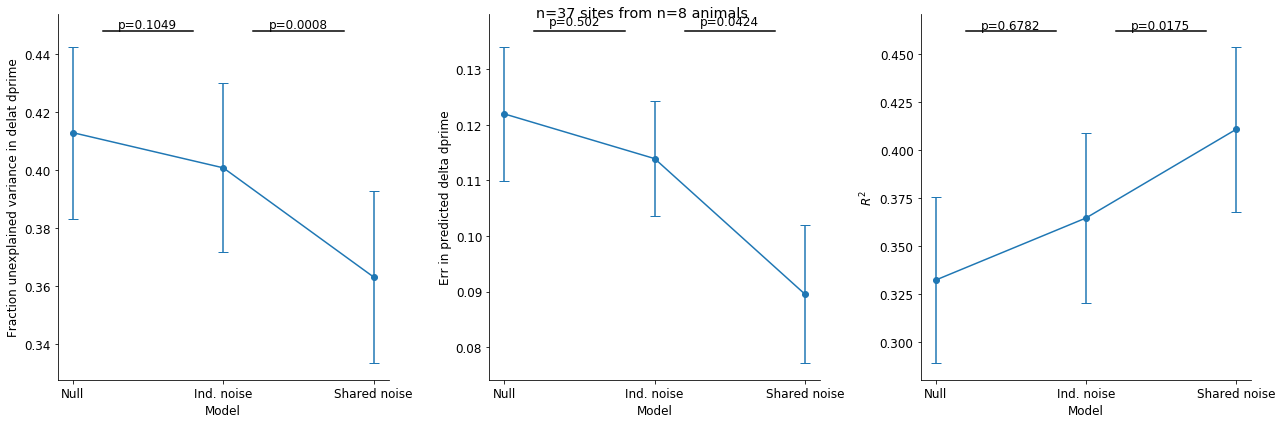

In [42]:
# summary of variance prediction and absolute delta dprime prediction
f, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].errorbar([0, 1, 2], [e1_std.mean(), e2_std.mean(), e3_std.mean()], yerr=[e1_std.sem(), e2_std.sem(), e3_std.sem()], marker="o", capsize=5)
ax[0].set_ylabel("Fraction unexplained variance in delat dprime")
ax[0].set_xlabel("Model")
ax[0].set_xticks([0, 1, 2])
ax[0].set_xticklabels(["Null", "Ind. noise", "Shared noise"])

# pvalues
yl = ax[0].get_ylim()[-1]
p = round(ss.wilcoxon(e1_std, e2_std).pvalue, 4)
ax[0].plot([0.2, 0.8], [yl, yl], "k-")
ax[0].text(0.3, yl+0.001, f"p={p}")

p = round(ss.wilcoxon(e2_std, e3_std).pvalue, 4)
ax[0].plot([1.2, 1.8], [yl, yl], "k-")
ax[0].text(1.3, yl+0.001, f"p={p}")


# mean
ax[1].errorbar([0, 1, 2], [e1_mean.mean(), e2_mean.mean(), e3_mean.mean()], yerr=[e1_mean.sem(), e2_mean.sem(), e3_mean.sem()], marker="o", capsize=5)
ax[1].set_ylabel("Err in predicted delta dprime")
ax[1].set_xlabel("Model")
ax[1].set_xticks([0, 1, 2])
ax[1].set_xticklabels(["Null", "Ind. noise", "Shared noise"])

# pvalues
yl = ax[1].get_ylim()[-1]
p = round(ss.wilcoxon(e1_mean, e2_mean).pvalue, 4)
ax[1].plot([0.2, 0.8], [yl, yl], "k-")
ax[1].text(0.3, yl+0.001, f"p={p}")

p = round(ss.wilcoxon(e2_mean, e3_mean).pvalue, 4)
ax[1].plot([1.2, 1.8], [yl, yl], "k-")
ax[1].text(1.3, yl+0.001, f"p={p}")

un_animal = np.unique([s[:3] for s in df.site])
f.suptitle(f"n={len(e1_std)} sites from n={len(un_animal)} animals")

# r2
ax[2].errorbar([0, 1, 2], [r2_1.mean(), r2_2.mean(), r2_3.mean()], yerr=[r2_1.sem(), r2_2.sem(), r2_3.sem()], marker="o", capsize=5)
ax[2].set_ylabel(r"$R^2$")
ax[2].set_xlabel("Model")
ax[2].set_xticks([0, 1, 2])
ax[2].set_xticklabels(["Null", "Ind. noise", "Shared noise"])

# pvalues
yl = ax[2].get_ylim()[-1]
p = round(ss.wilcoxon(r2_1, r2_2).pvalue, 4)
ax[2].plot([0.2, 0.8], [yl, yl], "k-")
ax[2].text(0.3, yl+0.001, f"p={p}")

p = round(ss.wilcoxon(r2_2, r2_3).pvalue, 4)
ax[2].plot([1.2, 1.8], [yl, yl], "k-")
ax[2].text(1.3, yl+0.001, f"p={p}")

f.tight_layout()

In [58]:
r2_3.index.get_level_values(1)

Int64Index([331, 331, 331, 331, 331, 331, 294, 294, 322, 322, 331, 322, 322,
            322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 331, 322,
            331, 322, 331, 322, 331, 322, 331, 322, 331, 322, 322],
           dtype='int64', name='batch')

In [64]:
mask = [True] * r2_3.shape[0] #r2_3.index.get_level_values(1)==331
(((r2_3[mask] - r2_1[mask]) > 0) | ((e1_mean[mask] - e3_mean[mask]) > 0)).sum() / r2_3[mask].shape[0]

0.7027027027027027

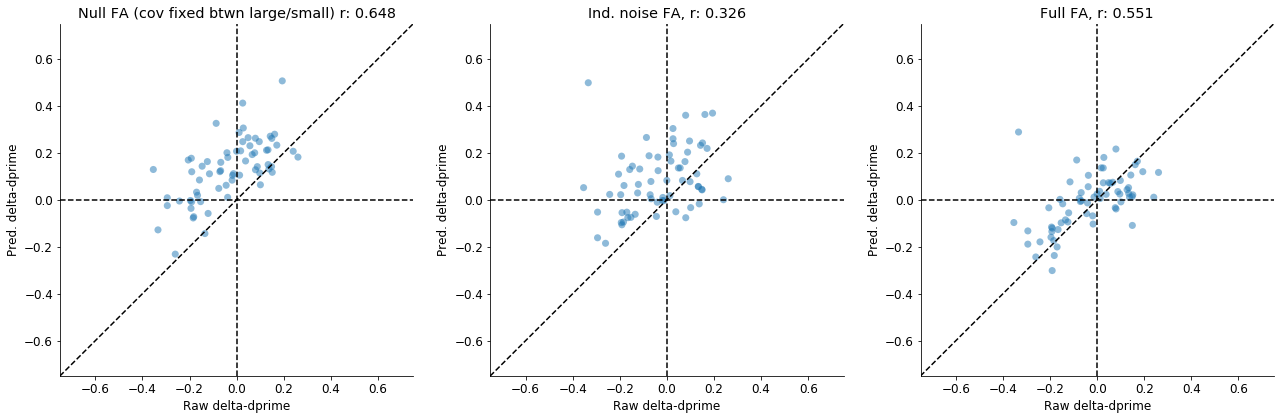

In [65]:
# example site
m = (df.site=="ARM033a") & (df.batch==331) #df.site=="CRD017c" #(df.bp_dp_sem<1) & (df.sp_dp_sem<1) #(df.batch==331) #| (df.batch==331)
f, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].scatter(df[m]["delta"], df_null_fa[m]["delta"], s=50, alpha=0.5, edgecolor="none")
cc = np.corrcoef(df[m]["delta"], df_null_fa[m]["delta"])[0, 1]
ax[0].set_title(f"Null FA (cov fixed btwn large/small) r: {round(cc, 3)}")

ax[1].scatter(df[m]["delta"], df_ind_fa[m]["delta"], s=50, alpha=0.5, edgecolor="none")
cc = np.corrcoef(df[m]["delta"], df_ind_fa[m]["delta"])[0, 1]
ax[1].set_title(f"Ind. noise FA, r: {round(cc, 3)}")

ax[2].scatter(df[m]["delta"], df_full_fa[m]["delta"], s=50, alpha=0.5, edgecolor="none")
cc = np.corrcoef(df[m]["delta"], df_full_fa[m]["delta"])[0, 1]
ax[2].set_title(f"Full FA, r: {round(cc, 3)}")

for a in ax:
    a.axvline(0, linestyle="--", color="k")
    a.axhline(0, linestyle="--", color="k")
    a.plot([-1, 1], [-1, 1], "k--")
    a.set_xlim(-0.75, 0.75)
    a.set_ylim(-0.75, 0.75)
    a.set_xlabel("Raw delta-dprime")
    a.set_ylabel("Pred. delta-dprime")

f.tight_layout()